In [109]:
%%capture
import IPython
import sys

# !{sys.executable} -m pip install ipywidgets
# IPython.Application.instance().kernel.do_shutdown(True)  # has to restart kernel so changes are used

In [110]:
%%capture

# !pip install -U transformers
# !pip install -U sagemaker
# !pip install torch==1.11.0
# !pip install torchtext==0.12.0

In [111]:
import transformers
import sagemaker
import torch
import json
import os
import boto3
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from pathlib import Path

from sagemaker.pytorch.model import PyTorchModel
from sagemaker.predictor import Predictor
from datetime import datetime
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.utils import name_from_base
from sagemaker.huggingface import HuggingFaceModel
from sagemaker.predictor import Predictor

from datetime import datetime
import threading
import time
import matplotlib.pyplot as plt
import pandas as pd
import tarfile

In [112]:
sess = sagemaker.Session()
sagemaker_session_bucket = 'sagemaker-godeltech'
if sagemaker_session_bucket is None and sess is not None:
    sagemaker_session_bucket = sess.default_bucket()

#put SageMaker role here if you're running this notebook locally
role = os.getenv('SAGEMAKER_ROLE')


sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker bucket: sagemaker-godeltech
sagemaker session region: eu-west-1


In [113]:
MODEL_NAME = 'unitary/unbiased-toxic-roberta'

tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)
model = transformers.AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, return_dict=False)

In [114]:
# Create directory for model artifacts
Path("normal_model/").mkdir(exist_ok=True)
Path("traced_model/").mkdir(exist_ok=True)

# Prepare sample input for jit model tracing
seq = """
Odin’s attitude was similar to that of the hero of German philosopher Friedrich Nietzsche’s Thus Spoke Zarathustra: “You say it is the good cause
that hallows even war? I say unto you: it is the good war that hallows any cause.” Odin boasts in the Eddic poem The Song of Gray-Beard, 
“I incited the princes never to make peace.
"""
max_length = 512

tokenized_sequence_pair = tokenizer.encode_plus(
    seq, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt"
)

example = tokenized_sequence_pair["input_ids"], tokenized_sequence_pair["attention_mask"]

traced_model = torch.jit.trace(model.eval(), example)

model.save_pretrained('normal_model/')
traced_model.save("traced_model/model.pth") # The `.pth` extension is required.

In [115]:
!tar -czvf normal_model.tar.gz -C normal_model . && mv normal_model.tar.gz normal_model/
!tar -czvf traced_model.tar.gz -C traced_model . && mv traced_model.tar.gz traced_model/

./
./config.json
./pytorch_model.bin
./
./model.pth


In [116]:
normal_model_url = sess.upload_data(
    path="normal_model/normal_model.tar.gz",
    key_prefix="neuron-experiments/normal-model",
)

traced_model_url = sess.upload_data(
    path="traced_model/traced_model.tar.gz",
    key_prefix="neuron-experiments/traced-model",
)
print('Files were uploaded')

Files were uploaded


In [117]:
flavour = "normal"
hardware = "g4dn"
date_string = datetime.now().strftime("%Y%m-%d%H-%M%S")

prefix = "neuron-experiments/toxic-bert"
flavour = "normal"
date_string = datetime.now().strftime("%Y%m-%d%H-%M%S")

normal_sm_model = HuggingFaceModel(
    model_data=normal_model_url,
    predictor_cls=Predictor,
    transformers_version="4.12.3",
    pytorch_version='1.9.1',
    role=role,
    entry_point="inference_gpuinf1.py",
    source_dir="aux",
    py_version="py38",
    name=f"{flavour}-toxicbert-{date_string}",
    env={"SAGEMAKER_CONTAINER_LOG_LEVEL": "10"},
)

In [118]:
%%time

normal_predictor = normal_sm_model.deploy(
    instance_type="ml.g4dn.xlarge",
    initial_instance_count=1,
    endpoint_name=f"toxicbert-{flavour}-{hardware}-{date_string}",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

----------!CPU times: user 35.3 s, sys: 5.34 s, total: 40.6 s
Wall time: 11min 56s


In [119]:
kayne_west_tweet = """
I’m a bit sleepy tonight but when I wake up I’m going death con 3 On JEWISH PEOPLE.
The funny thing is I actually can’t be Anti Semitic because black people are actually Jew 
also You guys have toyed with me and tried to black ball anyone whoever opposes your agenda.
"""

In [122]:
compilation_job_name = name_from_base("godel")
hardware = "inf1"
output_model_path = f"s3://{sagemaker_session_bucket}/{prefix}/neo-compilations/{hardware}-model"

compiled_inf1_model = HuggingFaceModel(
    model_data=traced_model_url,
    predictor_cls=Predictor,
    transformers_version="4.12.3",
    pytorch_version='1.9.1',
    role=role,
    entry_point="inference_gpuinf1.py",
    source_dir="aux",
    py_version="py37",
    name=f"toxicbert-inf1-{date_string}",
    env={"SAGEMAKER_CONTAINER_LOG_LEVEL": "10"},
)

In [123]:
%%time

compiled_inf1_model = compiled_inf1_model.compile(
    target_instance_family=f"ml_{hardware}",
    input_shape={"input_ids": [1, 512], "attention_mask": [1, 512]},
    job_name=compilation_job_name,
    role=role,
    framework="pytorch",
    framework_version="1.9.1",
    output_path=output_model_path,
    compiler_options=json.dumps("--dtype int64"),
    compile_max_run=900,
)

??????????????????????????????............................................................................................................!CPU times: user 641 ms, sys: 165 ms, total: 806 ms
Wall time: 11min 56s


In [124]:
%%time

compiled_inf1_predictor = compiled_inf1_model.deploy(
    instance_type="ml.inf1.xlarge",
    initial_instance_count=1,
    endpoint_name=f"toxicbert-{hardware}-{date_string}",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

-----------!CPU times: user 16.7 s, sys: 2.74 s, total: 19.5 s
Wall time: 6min 35s


In [194]:
num_preds = 1000
num_threads = 5

In [195]:
gpu_times = []
gpu_threads = []


def gpu_predict():
    thread_id = threading.get_ident()
    print(f"Thread {thread_id} started")

    for i in range(num_preds):
        tick = time.time()
        response = normal_predictor.predict(seq)
        tock = time.time()
        gpu_times.append((thread_id, tock - tick))


[gpu_threads.append(threading.Thread(target=gpu_predict, daemon=False)) for i in range(num_threads)]
[gpu_t.start() for gpu_t in gpu_threads]

# Wait for threads, get an estimate of total time
start = time.time()
[gpu_t.join() for gpu_t in gpu_threads]
end = time.time() - start

Thread 140546579347008 started
Thread 140546570954304 started
Thread 140546528990784 started
Thread 140546596132416 started
Thread 140546630743616 started


In [196]:
GPU_TPS = (num_preds * num_threads) / end

gpu_t = [duration for thread__id, duration in gpu_times]
gpu_latency_percentiles = np.percentile(gpu_t, q=[50, 90, 95, 99])

In [197]:
inf_times = []
inf_threads = []

def inf_predict():
    thread_id = threading.get_ident()
    print(f"Thread {thread_id} started")

    for i in range(num_preds):
        tick = time.time()
        response = compiled_inf1_predictor.predict(seq)
        tock = time.time()
        inf_times.append((thread_id, tock - tick))



[inf_threads.append(threading.Thread(target=inf_predict, daemon=False)) for i in range(num_threads)]
[inf_t.start() for inf_t in inf_threads]

# Wait for threads, get an estimate of total time
start = time.time()
[inf_t.join() for inf_t in inf_threads]
end = time.time() - start

Thread 140546570954304 startedThread 140546596132416 started
Thread 140546630743616 started

Thread 140546528990784 started
Thread 140546604525120 started


In [198]:
INF_TPS = (num_preds * num_threads) / end

inf_t = [duration for thread__id, duration in inf_times]
inf_latency_percentiles = np.percentile(inf_t, q=[50, 90, 95, 99])

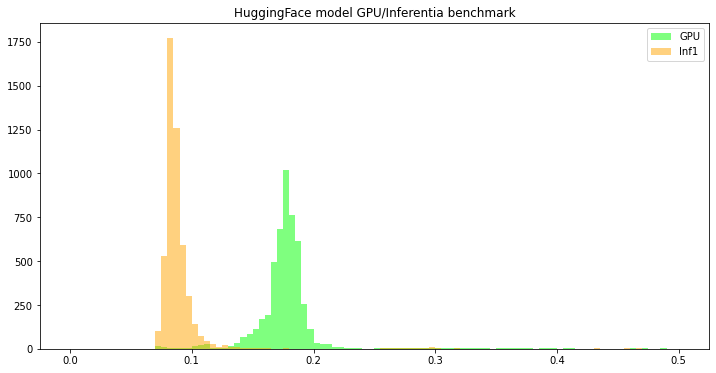

In [199]:
bins = np.linspace(0, 0.5, 101)
plt.figure(figsize=(12,6))
plt.hist(gpu_t, bins, alpha=0.5, label='GPU', color='lime')
plt.hist(inf_t, bins, alpha=0.5, label='Inf1', color='orange')
plt.legend(loc='upper right')
plt.title("HuggingFace model GPU/Inferentia benchmark")
plt.show()

In [200]:
latency_df = pd.DataFrame([gpu_latency_percentiles, inf_latency_percentiles], index=['GPU', 'Inf1'], columns=[50, 90, 95, 99])
latency_df

,50,90,95,99
GPU,0.177562,0.191632,0.200528,0.355553
Inf1,0.085264,0.098579,0.107379,0.285039


In [201]:
print(f"GPU: Rough request throughput/second is {GPU_TPS}")
print(f"Inferentia: Rough request throughput/second is {INF_TPS}")

GPU: Rough request throughput/second is 27.69804758053417
Inferentia: Rough request throughput/second is 52.232144669515655


In [127]:
normal_predictor.delete_model()
normal_predictor.delete_endpoint()
compiled_inf1_predictor.delete_model()
compiled_inf1_predictor.delete_endpoint()